In this notebook we simulate the distribution of family sizes according to WF and coalescent using msprime.

In [46]:
%matplotlib inline 
import msprime
from matplotlib import pyplot as plt
import numpy as np
import seaborn

In [47]:
msprime.simulate?

In [604]:
popsize = 100000 #haploid
sample_size = popsize//4
endtime = 1+1e-8 #we want to make sure that Wright-Fisher stops just after the generation


tsWF = msprime.simulate(sample_size = sample_size, Ne=popsize/2, 
                        end_time = endtime, model = msprime.DiscreteTimeWrightFisher(popsize/2)) 
tsCoal = msprime.simulate(sample_size = sample_size, Ne=popsize/2, end_time = endtime)

treeWF = tsWF.first() 
treeCoal = tsCoal.first() 


In [605]:
fam_sizesWF = [treeWF.get_num_leaves(parent) for parent in treeWF.roots]
fam_sizesCoal = [treeCoal.get_num_leaves(parent) for parent in treeCoal.roots]
print("number of remaining lineages, WF :", len(fam_sizesWF) )
print("number of remaining lineages, Coal :", len(fam_sizesCoal) )
print("prop of no kids, WF :", 1- len(fam_sizesWF)/popsize )
print("prop of no kids, Coal :", 1- len(fam_sizesCoal)/popsize )
print("expectation under WF", (1-1/popsize)**popsize )



number of remaining lineages, WF : 22178
number of remaining lineages, Coal : 22259
prop of no kids, WF : 0.77822
prop of no kids, Coal : 0.7774099999999999
expectation under WF 0.3678776017682465


Note the number of lineages in WF is smaller than in Coal, as observed in Bhaskar, Clark, and Song. Now consider the distribution of family sizes:

Text(0, 0.5, 'number of families')

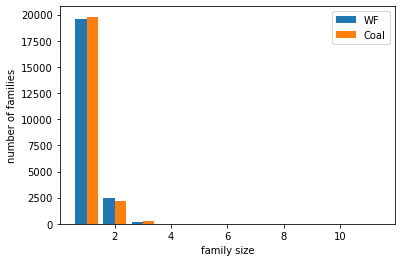

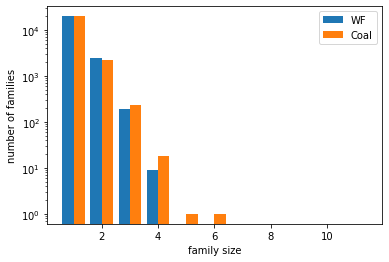

In [606]:
hists = plt.hist([fam_sizesWF,fam_sizesCoal],bins = np.arange(0.5,12,1),label = ("WF","Coal"),log = False)
histWF = hists[0][0]
histCoal = hists[0][1]
plt.legend(loc = "upper right")
plt.xlabel("family size")
plt.ylabel("number of families")
plt.figure(2)
hists = plt.hist([fam_sizesWF,fam_sizesCoal],bins = np.arange(0.5,12,1),label = ("WF","Coal"),log = True)
histWF = hists[0][0]
histCoal = hists[0][1]
plt.legend(loc = "upper right")
plt.xlabel("family size")
plt.ylabel("number of families")

So there is a substantial excess of large families in the coalescent, and these happen in real populations, but they are not very common.

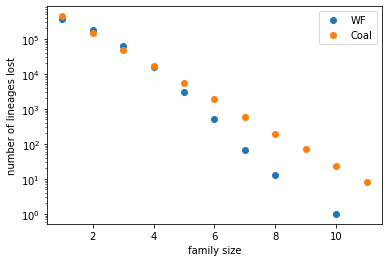

In [51]:
bins = (hists[1]+0.5)[:-1]
plt.plot(bins, histWF,'o',label = "WF")
plt.plot(bins, histCoal,'o',label = "Coal")
plt.yscale('log')
plt.xlabel("family size")
plt.ylabel("number of lineages lost")
plt.legend(loc = "upper right")

These very large families do not contribute a very large fraction of genetic drift, as the number of lineages lost to such large families is also low:




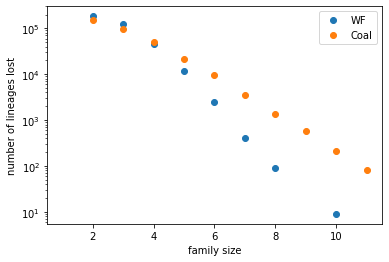

In [7]:
bins = (hists[1]+0.5)[:-1]
plt.plot(bins, (bins-1)*histWF,'o',label = "WF")
plt.plot(bins, (bins-1)*histCoal,'o',label = "Coal")
plt.yscale('log')
plt.xlabel("family size")
plt.ylabel("number of lineages lost")
plt.legend(loc = "upper right")



We have the unnormalized truncated distribution of family sizes (i.e., we don't have families of size zero). But that can easily be fixed!

In [52]:
nokidsWF = popsize - np.sum(histWF)
nokidsCoal = popsize - np.sum(histCoal)

In [53]:
fullhistWF = np.array([nokidsWF]+list(histWF))/popsize
fullhistCoal = np.array([nokidsCoal]+list(histCoal))/popsize
fullbins = hists[1]-0.5

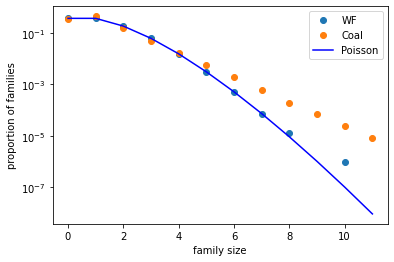

In [56]:
import scipy.special
from scipy.special import factorial
plt.plot(fullbins, fullhistWF,'o',label = "WF")
plt.plot(fullbins, fullhistCoal,'o',label = "Coal")
plt.plot(fullbins,np.exp(-1)/factorial(fullbins),label = "Poisson",color = 'b')
p=0.7
plt.yscale('log')
plt.xlabel("family size")
plt.ylabel("proportion of families")
plt.legend(loc = "upper right")

assert np.sum(fullhistWF)==1
assert np.sum(fullhistCoal)==1

We would like to compute the mean and variance of each family size distribution. Wright-Fisher should be 1 for both if we include 0 family sizes. We are especially interested in the ration of variance to mean, as this can be used as a diagnostic for non-Wright-Fisher behavior. Let us first compute this straight from the simulations, which will give us the ratio for families that have offspring, and then we will do the same for the entire families, from the histograms.  

In [57]:
print("family size mean for WF: ", np.mean(fam_sizesWF))
print("family size mean for Coal: ", np.mean(fam_sizesCoal))

family size mean for WF:  1.5818479780819144
family size mean for Coal:  1.500368340427575


In [58]:
print("variance for WF: ", np.var(fam_sizesWF))
print("variance for Coal: ", np.var(fam_sizesCoal))

variance for WF:  0.6610511410155552
variance for Coal:  0.7516150108437999


So the variances are not vastly different, but the ratio is definitely not one, as the truncated poisson is not poisson (Duh)

In [59]:
meanWF = np.sum(fullhistWF * np.arange(0,len(fullhistWF)))
varWF = np.sum(fullhistWF * np.arange(0,len(fullhistWF)) **2) - meanWF**2
print("mean: ", meanWF)
print("variance:",varWF)
print("dispersion ratio, WF: ", varWF/meanWF)

mean:  1.0000000000000002
variance: 0.9997459999999996
dispersion ratio, WF:  0.9997459999999994


In [60]:
meanCoal = np.sum(fullhistCoal * np.arange(0,len(fullhistCoal)))
varCoal = np.sum(fullhistCoal * np.arange(0,len(fullhistCoal)) **2) - meanCoal**2
print("mean: ", meanCoal)
print("variance:",varCoal)
print("dispersion ratio, Coal: ", varCoal/meanCoal)

mean:  0.999975
variance: 1.0010589993749999
dispersion ratio, Coal:  1.0010840264756617


So if the difference in family sizes does not affect the variance (i.e., the overall drift). But it seems statistics that depend on fast allele expansion, that is, (n-1)-tons and load+ fixation of deleterious alleles. 

Let us look at n-1-tons. Try to count the number of multiple coalescences in a tree. 


In [453]:
def root_child_leaves(tree):
    rt = tree.get_root()
    root_children = tree.get_children(rt)
    children_leaves =[tree.get_num_leaves(child) for child in root_children]
    return children_leaves
def count_multicoal_tree_coal(tree, maxk=10):
    """Number of times the descendants of a node are in the same generation as that node. """
    multiple_counts = np.zeros(maxk+1)
    for node in tree.nodes():
        parent = tree.parent(node)
        
        
        gen_node = np.floor(tree.get_time(node))
        
        if isinstance(parent,int) and parent >=0:
            if gen_node == np.floor(tree.get_time(parent)): # do not count multiple times
                continue
        
        children = tree.get_children(node)
        if len(children) == 0:
            continue
        actual_children = [child for child in children if (np.floor(tree.get_time(child))==gen_node 
                                                           and isinstance(child, int))]
        n_actual_children = 2 + len([child for child in actual_children if len(tree.get_children(child))==2]) # All nodes have at least two children, including children
        # Now iterate over the children's children
        while len(actual_children) !=0:
            current_child_node = actual_children.pop(0)
            
            grandchildren = tree.get_children(current_child_node)
            actual_grandchildren = [child for child in grandchildren if (np.floor(tree.get_time(child))==gen_node 
                                                                         and isinstance(child, int))]
            n_actual_children += len([child for child in actual_grandchildren if len(tree.get_children(child))==2])
            actual_children.extend(actual_grandchildren)
        multiple_counts[n_actual_children]+=1
                             
            
            
    return multiple_counts

def count_multicoal_tree_WF(tree, maxk=10):
    """Number of times the descendants of a node are within 1 generation of the node"""
   
    multiple_counts = np.zeros(maxk+1)
                              
    count_multiple=0
    for node in tree.nodes():
        children = tree.get_children(node)
        assert(len(children) <= maxk)
        if len(children) >0:
            multiple_counts[len(children)]+=1
        #if len(children) >=k: # To avoid leaves counting negatively
        #count_multiple += 1
    return multiple_counts


In [590]:
sampsize = 20
popsize = 40
nsims = round(800 * sampsize*np.log(sampsize))
sizelimit = 20
max_clades = []
multis = []
Ts = [] # the time of the oldest child of the root
for sim in range(nsims):
    tsCoal = msprime.simulate(sample_size = sampsize, Ne=popsize/2)
    tree = tsCoal.first()
    max_clade = max(root_child_leaves(tree))
    multi = count_multicoal_tree_coal(tree, maxk=sizelimit)
    max_clades.append(max_clade)
    multis.append(multi)    
    Ts.append(max((tree.get_time(child) for child in tree.get_children(tree.root)) ))
print("mean TMRCA =", np.mean(Ts)) 

mean TMRCA = 35.98749579712816


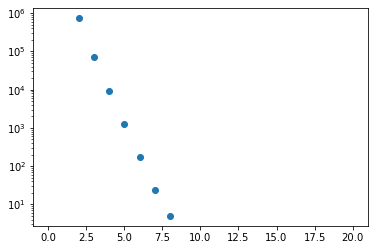

In [591]:
distribution_coalsize_coal = np.sum(multis,axis=0)
plt.plot(distribution_coalsize_coal,'o')
plt.yscale("log")

Text(0, 0.5, 'number of clades')

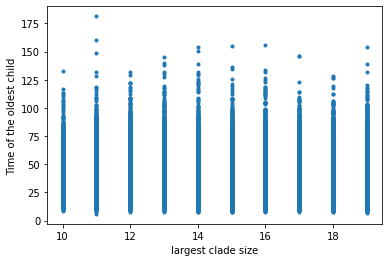

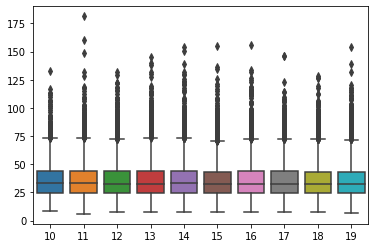

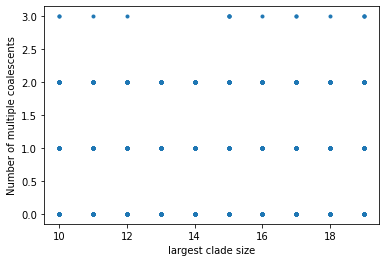

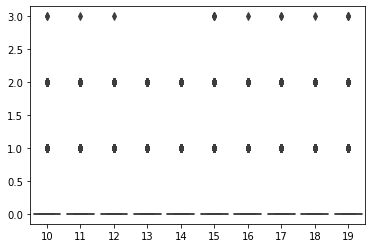

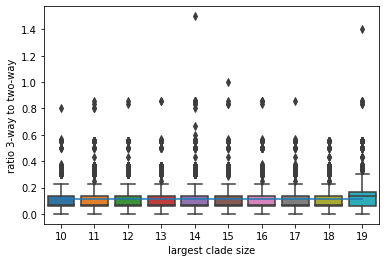

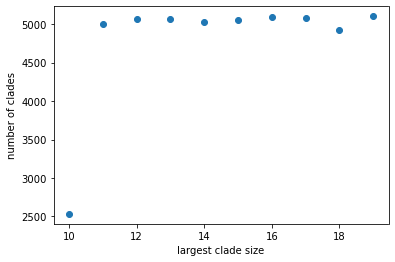

In [592]:

plot_coalsize = 4
plt.plot(max_clades,Ts,'.')
plt.xlabel("largest clade size")
plt.ylabel("Time of the oldest child")
plt.figure()
seaborn.boxplot(x=max_clades, y=Ts)
plt.figure()
plt.plot(max_clades, np.array(multis)[:,plot_coalsize], '.')
plt.xlabel("largest clade size")
plt.ylabel("Number of multiple coalescents")

plt.figure()
seaborn.boxplot(x=max_clades, y=np.array(multis)[:,plot_coalsize])
plt.figure()


rg = range(sampsize//2,sampsize)

overall_3_2 = np.mean(np.array(multis)[:,3]/np.array(multis)[:,2])
seaborn.boxplot(x=max_clades, y=np.array(multis)[:,3]/np.array(multis)[:,2])
seaborn.lineplot(x=range(len(rg)), y=overall_3_2*np.ones(len(rg)))

plt.ylabel("ratio 3-way to two-way")
plt.xlabel("largest clade size")
plt.figure()

plt.plot(rg, [np.sum(np.array(max_clades)==i) for i in rg],'o')
plt.xlabel("largest clade size")
plt.ylabel("number of clades")

Repeat with WF

In [593]:
max_clades = []
multis = []
Ts = [] # the time of the oldest child of the root
for sim in range(nsims):
    tsWF = msprime.simulate(sample_size = sampsize, Ne=popsize/2,model = msprime.DiscreteTimeWrightFisher(popsize/2))
    tree = tsWF.first()
    max_clade = max(root_child_leaves(tree))
    multi = count_multicoal_tree_WF(tree, maxk=sizelimit)
    max_clades.append(max_clade)
    multis.append(multi)    
    Ts.append(max((tree.get_time(child) for child in tree.get_children(tree.root)) ))
    
distribution_coalsize_WF = np.sum(multis,axis=0)

In [594]:
assert (np.sum(multis[5]*range(-1,len(multis[1])-1)) == sampsize -1), " total coalescences should be sampsize -1"

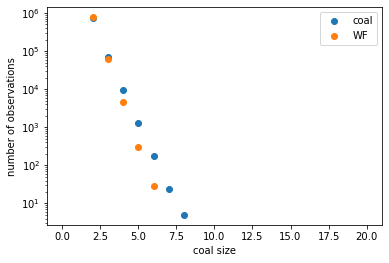

In [595]:

plt.plot(distribution_coalsize_coal,'o',label = "coal")
plt.plot(distribution_coalsize_WF,'o',label= "WF")

plt.legend(loc = "upper right")
plt.xlabel("coal size")
plt.ylabel("number of observations")
plt.yscale("log")

In [596]:
print("mean TMRCA =", np.mean(Ts)) 

mean TMRCA = 35.40609613619294


Text(0.5, 0, 'largest clade size')

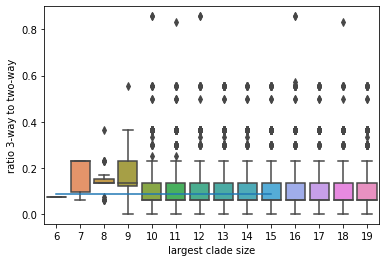

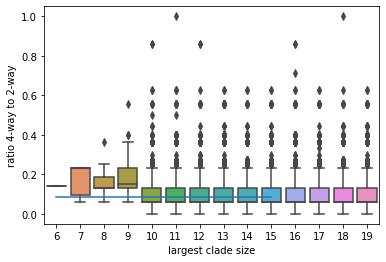

In [597]:
plt.figure()


rg = range(sampsize//2,sampsize)

overall_3_2 = np.mean(np.array(multis)[:,3]/np.array(multis)[:,2])
seaborn.boxplot(x=max_clades, y=np.array(multis)[:,3]/np.array(multis)[:,2])
seaborn.lineplot(x=range(len(rg)), y=overall_3_2*np.ones(len(rg)))

plt.ylabel("ratio 3-way to two-way")
plt.xlabel("largest clade size")

plt.figure()


rg = range(sampsize//2,sampsize)

seaborn.boxplot(x=max_clades, y=np.sum(np.array(multis)[:,3:],axis=1)/np.array(multis)[:,2])
seaborn.lineplot(x=range(len(rg)), y=overall_3_2*np.ones(len(rg)))

plt.ylabel("ratio 4-way to 2-way")
plt.xlabel("largest clade size")

Text(0, 0.5, 'number of trees')

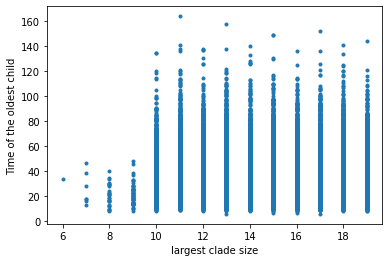

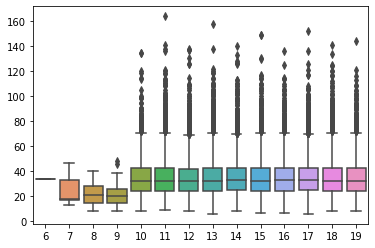

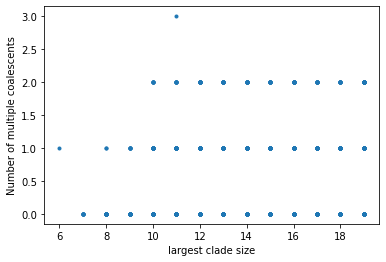

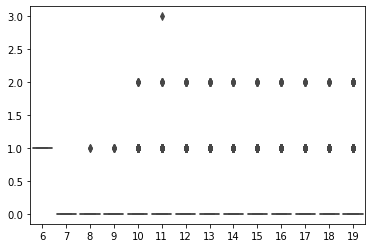

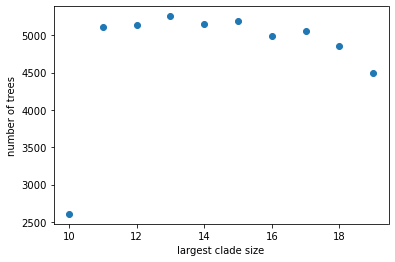

In [598]:

plot_coalsize = 4
plt.plot(max_clades,Ts,'.')
plt.xlabel("largest clade size")
plt.ylabel("Time of the oldest child")
plt.figure()
seaborn.boxplot(x=max_clades, y=Ts)
plt.figure()
plt.plot(max_clades, np.array(multis)[:,plot_coalsize], '.')
plt.xlabel("largest clade size")
plt.ylabel("Number of multiple coalescents")

plt.figure()
seaborn.boxplot(x=max_clades, y=np.array(multis)[:,plot_coalsize])



plt.figure()

plt.plot(rg, [np.sum(np.array(max_clades)==i) for i in rg],'o')
plt.xlabel("largest clade size")
plt.ylabel("number of trees")

In [599]:
max_clades = []
multis = []
Ts = [] # the time of the oldest child of the root
for sim in range(nsims):
    tsmix = msprime.simulate(end_time = 20, sample_size = sampsize, Ne=popsize/2,model = msprime.DiscreteTimeWrightFisher(popsize/2))
    tsmix = msprime.simulate(Ne=popsize/2, from_ts=tsmix)
    tree = tsmix.first()
    max_clade = max(root_child_leaves(tree))
    multi = count_multicoal_tree_coal(tree, maxk=sizelimit)
    max_clades.append(max_clade)
    multis.append(multi)    
    Ts.append(max((tree.get_time(child) for child in tree.get_children(tree.root)) ))
    
distribution_coalsize_mix = np.sum(multis,axis=0)

Text(0, 0.5, 'number of clades')

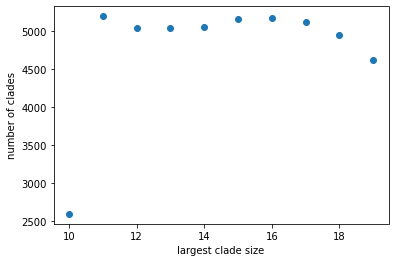

In [600]:
plt.plot(rg, [np.sum(np.array(max_clades)==i) for i in rg],'o')
plt.xlabel("largest clade size")
plt.ylabel("number of clades")